## 1) CIFAR-10  

 우리가 이번에 모델을 사용해서 풀어야 할 문제가 무엇인지 확인해보도록 합시다. CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있습니다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)입니다. MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠습니다.

- CIFAR-10 from Tensorflow dataset
https://www.tensorflow.org/datasets/catalog/cifar10?hl=ko

### 1. 데이터셋 준비  

패키지 설치  

$ pip install tensorflow-datasets

### 2. 라이브러리 설치

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [3]:
# Out Of Memory 문제 방지 (메모리 청소)

tf.keras.backend.clear_session()

In [4]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import urllib3
urllib3.disable_warnings()
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

# setattr(tfds.image_classification.cats_vs_dogs,
#         '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


❗️ tfds.load()는 기본적으로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드합니다. 데이터셋 크기가 커서 하나의 폴더에 모아놓고 사용하는 것도 좋은 방법이므로, ~/aiffel 프로젝트 폴더가 아닌 기본 경로에 다운 받아 사용하시면 됩니다. 혹시 데이터셋 경로를 바꾸고 싶으시다면, data_dir 인자를 사용하세요.

In [6]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})


In [7]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(2936, shape=(), dtype=int64)
tf.Tensor(734, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않습니다.

## 2) Input Normalization  

 이미지 데이터의 경우 픽셀 정보를 0 ~ 255 사이의 값으로 가지는데,  
 이를 255로 나누어주면 0 ~ 1.0 사이의 값으로 변경

 Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 방지함  

 ![image_3GLaa5Y.max-800x600.png](attachment:image_3GLaa5Y.max-800x600.png)

In [8]:
# 입력 이미지 정규화 및 리사이즈
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (224, 224))
    return image, label

In [9]:
# 정규화 함수 적용 및 batch_size 조절
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(1000)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 메모리 사용 줄이는 법

ds = ds.shuffle(200) 대신 ds.shuffle(1000) 혹은 아예 사용하지 않기  
num_parallel_calls=1 여기서 1 대신 tf.data.experimental.AUTOTUN을 사용  

In [10]:
ds_info.features["label"].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

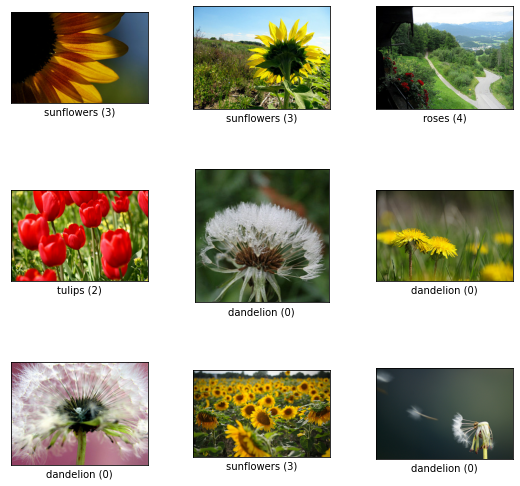

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

## 3) 블록 구성하기
![image-2.png](attachment:image-2.png)
### ResNet 블록 만들기

### ResNet 블록 만들기

In [12]:
# def build_resnet_block(input_layer,
#                        num_cnn=3,
#                        channel=64,
#                        block_num=1,
#                        is_50=False,
#                        is_plain=False):
#     # 입력 레이어
#     x = input_layer
#     # skip connection을 위한 identity 저장
#     identity = input_layer

#     # ResNet-34 블록 (Basic Block)
#     if not is_50:
#         # num_cnn 만큼 Conv 레이어를 쌓음
#         for cnn_num in range(num_cnn):
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3, 3),
#                 kernel_initializer='he_normal',
#                 padding='same',
#                 name=f'block{block_num}_conv{cnn_num + 1}'
#             )(x)

#             x = keras.layers.BatchNormalization(
#                 name=f'block{block_num}_bn_conv{cnn_num + 1}'
#             )(x)

#             x = keras.layers.Activation('relu',
#                 name=f'block{block_num}_activation{cnn_num + 1}'
#             )(x)

#     # ResNet-50 블록 (Bottleneck Block)
#     else:
#         # 첫 번째 1x1 Conv 레이어 (채널 수가 증가하지 않음)
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(1, 1),
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_conv1_1x1'
#         )(x)

#         x = keras.layers.BatchNormalization(
#             name=f'block{block_num}_bn_conv1_1x1'
#         )(x)

#         x = keras.layers.Activation('relu',
#             name=f'block{block_num}_activation1_1x1'
#         )(x)

#         # 두 번째 3x3 Conv 레이어 (채널 수 증가 없음)
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(3, 3),
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_conv2_3x3'
#         )(x)

#         x = keras.layers.BatchNormalization(
#             name=f'block{block_num}_bn_conv2_3x3'
#         )(x)

#         x = keras.layers.Activation('relu',
#             name=f'block{block_num}_activation2_3x3'
#         )(x)

#         # 세 번째 1x1 Conv 레이어 (채널 수 증가)
#         x = keras.layers.Conv2D(
#             filters=channel * 4,
#             kernel_size=(1, 1),
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_conv3_1x1'
#         )(x)

#         # Skip Connection (차원 맞추기)
#         if not is_plain:
#             # 차원이 다르면 1x1 Conv로 skip connection의 차원 맞추기
#             if identity.shape[-1] != channel * 4:
#                 identity = keras.layers.Conv2D(
#                     filters=channel * 4,
#                     kernel_size=(1, 1),
#                     kernel_initializer='he_normal',
#                     padding='same',
#                     name=f'block{block_num}_identity_conv_bottleneck'
#                 )(identity)

#             x = keras.layers.Add(name=f'block{block_num}_skip_bottleneck')([x, identity])

#     # 활성화 함수 (ReLU)
#     x = keras.layers.Activation('relu', name=f'block{block_num}_final_activation')(x)

#     return x


In [13]:
# resnet_input_layer = keras.layers.Input(shape=(224,224,3),name=f'input_layer')
# resnet_block_output = build_resnet_block(resnet_input_layer)

# # 블록 1개짜리 model 생성
# resnet_model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)

# resnet_model.summary()

### ResNet-34 모델

In [14]:
# def build_resnet(input_shape=(224,224,3),
#                 num_cnn_list=[3,4,6,3],
#                 channel_list=[64,128,256,512],
#                 num_classes=2,
#                 is_50=False,  # ResNet-34는 Basic Block
#                 is_plain=False  # Skip Connection 포함
#                 ):

#     assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

#     input_layer = keras.layers.Input(shape=input_shape,name='input_layer')  # input layer를 만들어둡니다.
#     output = input_layer

#     # 첫 CNN 레이어
#     output = keras.layers.Conv2D(
#         filters=64,
#         kernel_size=(7,7),
#         strides=(2, 2),
#         kernel_initializer='he_normal',
#         padding='same'
#     )(input_layer)

#     # BatchNormalization 레이어
#     output = keras.layers.BatchNormalization()(output)

#     # Activation 레이어
#     output = keras.layers.Activation('relu')(output)

#     # Max Pooling 레이어
#     output = keras.layers.MaxPooling2D(
#         pool_size=(3, 3),
#         strides=(2,2),
#         name=f'stage2_0_maxpooling'
#     )(output)

#     # config list들의 길이만큼 반복해서 블록을 생성합니다.
#     for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
#         for j in range(num_cnn):
#             # 첫 번째 레이어는 다운샘플링
#             stride = 2 if j == 0 and i > 0 else 1  # 블록의 첫 번째 레이어는 다운샘플링

#             # ResNet 블록 생성
#             output = build_resnet_block(
#                 input_layer=output,
#                 num_cnn=2,  # Basic Block은 2개의 Conv 레이어
#                 channel=channel,
#                 block_num=f'{i+1}_{j+1}',  # 블록 및 레이어 번호
#                 is_50=is_50,  # ResNet-34는 Basic Block
#                 is_plain=is_plain  # Skip Connection 포함
#             )

#     output = keras.layers.GlobalAveragePooling2D(
#         name='avg_pool')(output)
# #     output = keras.layers.Dense(1000, activation='relu', name='fc1')(output)
#     output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

#     model = keras.Model(
#         inputs=input_layer,
#         outputs=output
#     )
#     return model

In [15]:
# # ResNet 모델 생성
# resnet_34 = build_resnet()

# resnet_34.summary()

In [16]:
# # Plain Network 모델 생성
# plain_34 = build_resnet(is_50=False, is_plain=True)

# plain_34.summary()

## 4) ResNet-34와 Plain-34 비교  

모델의 성능 비교를 위해서 모델을 훈련하고 평가

In [17]:
# # batch size와 epoch 설정

# BATCH_SIZE = 256
# EPOCH = 15

In [18]:
# # 데이터셋 정의

# (ds_train, ds_test), ds_info = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:]'],     # test 데이터 없으므로 train 데이터 8:2로 분리
#     as_supervised=True,                       # 지도학습
#     shuffle_files=True,                       # 데이터 무작위
#     with_info=True,                           # ds_info : 데이터셋의 크기, 클래스 이름, 특징(features), 또는 기타 메타데이터
# )
# ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
# ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [19]:
# resnet_34.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
#     metrics=['accuracy'],
# )

In [20]:
# history_resnet_34 = resnet_34.fit(
#     ds_train,
#     # steps_per_epoch : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정
#     # validation_steps : 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정
#     steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

Dead Kernel 문제 발생!  


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9  
Warning: unknown JFIF revision number 0.00  
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9  
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9  

뜨면서 커널 종료됨
커널이 죽는 이유: **메모리 할당량 초과**

문제 추측 :  
1. plain-34부터 resnet-50까지 한 코드 블럭으로 구현하려고 하여 크기가 커짐
2. VGG보다 큰 이미지 데이터 + 제대로 전처리가 되지 않음

### 문제 해결 시도  

1. 코드 블럭 단순하게 짜보기 (34층 블럭, 50층 블럭 나누기)

In [21]:
def build_resnet34_block(input_layer,
                         num_cnn=1,
                         channel=64,
                         block_num=1,
                         stride=1,
                         is_plain=False):
    # 입력 레이어
    x = input_layer

    
    for cnn_num in range(1,num_cnn+1):
        # 각 단계의 첫 번째 블록(첫 단계 제외)에서 스트라이드 2 사용
        stride = 2 if cnn_num == 1 and block_num > 1 else 1
        
        # skip connection을 위한  이전 레이어의 출력 값 저장
        identity = x
        # ResNet-34 블록 (Basic Block)
        #CNN 레이어
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            strides=stride,
            padding='same',
#             name=f'stage{block_num}_{cnn_num}_conv1'
        )(x)
        # Batch Nomalization 레이어
        x = keras.layers.BatchNormalization(
#             name=f'stage{block_num}_{cnn_num}_bn1'
        )(x)
        # Activation 레이어
        x = keras.layers.Activation('relu',
#             name=f'stage{block_num}_{cnn_num}_relu1'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            padding='same',
#             name=f'stage{block_num}_{cnn_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
#             name=f'stage{block_num}_{cnn_num}_bn2'
        )(x)



        # Skip Connection
        if not is_plain:
            # 차원이 다르면 1x1 Conv로 skip connection의 차원 맞추기
            # if identity.shape[-1] != (channel * 4 if is_50 else channel): <- 오류 코드 channel * 4 대신
            if identity.shape[-1] != x.shape[-1]:
                identity = keras.layers.Conv2D(
                    filters=x.shape[-1],
                    kernel_size=(1, 1),
                    strides=stride,
                    padding='same',
#                     name=f'stage{block_num}_{cnn_num}_add'
                )(identity)

            # 잔차 연결 레이어
            x = keras.layers.Add()([x, identity])

        # 활성화 함수 (ReLU)
        x = keras.layers.Activation('relu')(x)

    return x


In [22]:
def build_resnet50_block(input_layer,
                         num_cnn=1,
                         channel=64,
                         stride=1,
                         block_num=1,
                         is_plain=False):
    # 입력 레이어
    x = input_layer

    
    for cnn_num in range(1,num_cnn+1):
        
        # 각 단계의 첫 번째 블록(첫 단계 제외)에서 스트라이드 2 사용
        stride = 2 if cnn_num == 1 and block_num > 1 else 1
        
        # skip connection을 위한  이전 레이어의 출력 값 저장
        identity = x
        
        # 첫 번째 1x1 Conv 레이어 (filter=(1,1))
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            strides=stride,
            padding='same',
#             name=f'stage{block_num}_{cnn_num}_conv1'
        )(x)
        x = keras.layers.BatchNormalization(
#             name=f'stage{block_num}_{cnn_num}_bn1'
        )(x)
        x = keras.layers.Activation('relu',
#             name=f'stage{block_num}_{cnn_num}_relu1'
        )(x)

        # 두 번째 3x3 Conv 레이어 (filter=(3,3))
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            padding='same',
#             name=f'stage{block_num}_{cnn_num}_conv2'
        )(x)
        x = keras.layers.BatchNormalization(
#             name=f'stage{block_num}_{cnn_num}_bn2'
        )(x)
        x = keras.layers.Activation('relu',
#             name=f'stage{block_num}_{cnn_num}_relu2'
        )(x)

        # 세 번째 1x1 Conv 레이어 (filter=(1,1), channel*4)
        x = keras.layers.Conv2D(
            filters=channel* 4,
            kernel_size=(1, 1),
            padding='same',
#             name=f'stage{block_num}_{cnn_num}_conv3'
        )(x)
        x = keras.layers.BatchNormalization(
#             name=f'stage{block_num}_{cnn_num}_bn3'
        )(x)


        # Skip Connection
        if not is_plain:
            # 차원이 다르면 1x1 Conv로 skip connection의 차원 맞추기
            # if identity.shape[-1] != (channel * 4 if is_50 else channel): <- 오류 코드 channel * 4 대신
            if identity.shape[-1] != x.shape[-1]:
                identity = keras.layers.Conv2D(
                    filters=x.shape[-1],
                    kernel_size=(1, 1),
                    strides=stride,
                    padding='same',
#                     name=f'stage{block_num}_{cnn_num}_add'
                )(identity)
                identity = keras.layers.BatchNormalization(
#                 name=f'stage{block_num}_{cnn_num}_add_bn'
                )(identity)

            # 잔차 연결 레이어
            x = keras.layers.Add()([x, identity])

        # 활성화 함수 (ReLU)
        x = keras.layers.Activation('relu')(x)

    return x


**잔차 연결 레이어 오류**  


if identity.shape[-1] != (channel * 4 if is_50 else channel): <- 오류!!!  
channel * 4를 못 이해함  
if identity.shape[-1] != x.shape[-1]: <- 이 코드로 바꿨더니 잘 동작함


### 데이터의 크기 줄이기 위해 아래 코드 사용

각 단계의 첫 번째 블록(첫 단계 제외)에서 스트라이드 2 사용  
stride = 2 if cnn_num == 1 and block_num > 1 else 1

In [23]:
def build_resnet34(input_shape=(224,224,3),
                   stride=1,
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=2,
                   is_plain=False  # Skip Connection 포함
                   ):
    
    #모델을 만들기 전에 num_cnn과 channel이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list) 
    
    input_layer = keras.layers.Input(shape=input_shape,name='input_layer')
    output = input_layer

    # 초기 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2, 2),
        padding='same'
    )(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=(2,2),
        padding='same',
        name=f'stage2_0_maxpooling'
    )(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet34_block(
            input_layer=output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            stride=stride
        )

    output = keras.layers.AveragePooling2D(
        name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [24]:
def build_resnet50(input_shape=(224,224,3),
                   stride=1,
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=5,
                   is_plain=False  # Skip Connection 포함
                   ):
    
    #모델을 만들기 전에 num_cnn과 channel이 같은 길이인지 확인
    assert len(num_cnn_list) == len(channel_list) 
    
    input_layer = keras.layers.Input(shape=input_shape,name='input_layer')
    output = input_layer

    # 초기 레이어
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=(2, 2),
        padding='same'
    )(input_layer)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=(2,2),
        padding='same',
        name=f'stage2_0_maxpooling'
    )(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet50_block(
            input_layer=output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i,
            stride=stride
        )

    output = keras.layers.AveragePooling2D(
        name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [25]:
# ResNet 모델 생성
resnet_34 = build_resnet34()
resnet_50 = build_resnet50()

resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_33[0][0]     
____________________________________________________________________________________________

In [27]:
# Plain Network 모델 생성
plain_34 = build_resnet34(is_plain=True)
plain_50 = build_resnet50(is_plain=True)


plain_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 112, 112, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_86[0][0]     
____________________________________________________________________________________________

In [28]:
plain_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 112, 112, 64) 256         conv2d_125[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 112, 112, 64) 0           batch_normalization_119[0][0]    
____________________________________________________________________________________________

**여전히 오류**  
2. 데이터 전처리 시도해보기

In [29]:
# batch size와 epoch 설정

# batch size 256 -> 32
BATCH_SIZE = 32
EPOCH = 30

In [30]:
#데이터셋 정의
# 5가지 꽃 종류 데이터
(dataset_train, dataset_test), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,                       # 지도학습
    with_info=True,                           # ds_info : 데이터셋의 크기, 클래스 이름, 특징(features), 또는 기타 메타데이터
)

# Print dataset information
print("Dataset Info:")
print(dataset_info)

Dataset Info:
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/aiffel/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [31]:
# 데이터 정규화, 리사이징
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) 
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing and prepare batches
batch_size = 32

train_ds = (dataset_train
                 .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(1000)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

validation_ds = (dataset_test
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))


In [32]:
# Example of accessing a batch of data
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32,)


In [33]:
# # 정규화,resize 함수 적용 및 batch_size 조절
# ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
# ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# # # 손상된 이미지 건너뛰기
# # ds_train = ds_train.filter(lambda x, y: x is not None)
# # ds_test = ds_test.filter(lambda x, y: x is not None)

# # # 전처리 확인
# # for image, label in ds_train.take(1):
# #     print(image.shape, label.shape)


In [34]:
print(type(ds_train))

<class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>


In [35]:
print(ds_info.splits['train[:80%]'].num_examples)
print(ds_info.splits['train[80%:]'].num_examples)

2936
734


In [36]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


## 4) ResNet-34와 Plain-34 비교  

모델의 성능 비교를 위해서 모델을 훈련하고 평가

In [37]:
resnet_34.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, clipnorm=5.0),
    metrics=['accuracy'],
)
plain_34.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, clipnorm=1.0),
    metrics=['accuracy'],
)

In [38]:
resnet_50.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, clipnorm=1.0),
    metrics=['accuracy'],
)
plain_50.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, clipnorm=1.0),
    metrics=['accuracy'],
)

In [39]:
# history_resnet_34 = resnet_34.fit(
#     ds_train,
#     # steps_per_epoch : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정
#     # validation_steps : 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정
#     steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=False,
# )
history_resnet_34 = resnet_34.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=validation_ds,
    verbose=1,
)

Epoch 1/15
92/92 [==============================] - 86s 427ms/step - loss: nan - accuracy: 0.2520 - val_loss: nan - val_accuracy: 0.2166
Epoch 2/15
92/92 [==============================] - 38s 405ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 3/15
92/92 [==============================] - 37s 401ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 4/15
92/92 [==============================] - 37s 402ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 5/15
92/92 [==============================] - 37s 402ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 6/15
92/92 [==============================] - 37s 402ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 7/15
92/92 [==============================] - 37s 402ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 8/15
92/92 [=======================

In [41]:
history_plain_34 = plain_34.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=validation_ds,
    verbose=1,
)

Epoch 1/15
92/92 [==============================] - 43s 402ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 2/15
92/92 [==============================] - 38s 404ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 3/15
92/92 [==============================] - 37s 400ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 4/15
92/92 [==============================] - 37s 402ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 5/15
92/92 [==============================] - 37s 401ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 6/15
92/92 [==============================] - 37s 401ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 7/15
92/92 [==============================] - 37s 401ms/step - loss: nan - accuracy: 0.2517 - val_loss: nan - val_accuracy: 0.2166
Epoch 8/15
92/92 [=======================

In [42]:
history_resnet_50 = resnet_50.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=validation_ds,
    verbose=1,
)

Epoch 1/15
92/92 [==============================] - 106s 1s/step - loss: 2.0592 - accuracy: 0.2364 - val_loss: 1.7034 - val_accuracy: 0.2166
Epoch 2/15
92/92 [==============================] - 90s 974ms/step - loss: 1.7025 - accuracy: 0.3174 - val_loss: 2.0270 - val_accuracy: 0.2166
Epoch 3/15
92/92 [==============================] - 90s 976ms/step - loss: 1.6367 - accuracy: 0.3334 - val_loss: 2.3245 - val_accuracy: 0.2166
Epoch 4/15
92/92 [==============================] - 90s 976ms/step - loss: 1.6091 - accuracy: 0.3464 - val_loss: 2.3530 - val_accuracy: 0.2166
Epoch 5/15
92/92 [==============================] - 90s 973ms/step - loss: 1.5616 - accuracy: 0.3692 - val_loss: 1.9925 - val_accuracy: 0.2207
Epoch 6/15
92/92 [==============================] - 90s 974ms/step - loss: 1.5684 - accuracy: 0.3593 - val_loss: 1.8020 - val_accuracy: 0.2439
Epoch 7/15
92/92 [==============================] - 90s 975ms/step - loss: 1.5653 - accuracy: 0.3542 - val_loss: 1.6286 - val_accuracy: 0.3134
E

In [45]:
history_plain_50 = plain_50.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=validation_ds,
    verbose=1,
)

Epoch 1/15
92/92 [==============================] - 90s 972ms/step - loss: 1.4078 - accuracy: 0.4312 - val_loss: 1.5137 - val_accuracy: 0.3992
Epoch 2/15
92/92 [==============================] - 90s 974ms/step - loss: 1.3989 - accuracy: 0.4421 - val_loss: 1.5410 - val_accuracy: 0.3978
Epoch 3/15
92/92 [==============================] - 90s 976ms/step - loss: 1.3832 - accuracy: 0.4513 - val_loss: 1.4451 - val_accuracy: 0.4114
Epoch 4/15
92/92 [==============================] - 90s 976ms/step - loss: 1.3760 - accuracy: 0.4550 - val_loss: 1.4955 - val_accuracy: 0.4196
Epoch 5/15
92/92 [==============================] - 90s 975ms/step - loss: 1.3608 - accuracy: 0.4421 - val_loss: 1.4596 - val_accuracy: 0.4537
Epoch 6/15
92/92 [==============================] - 90s 977ms/step - loss: 1.3639 - accuracy: 0.4510 - val_loss: 1.4715 - val_accuracy: 0.4142
Epoch 7/15
92/92 [==============================] - 90s 975ms/step - loss: 1.3619 - accuracy: 0.4523 - val_loss: 1.4675 - val_accuracy: 0.4210

**loss가 nan으로 나오는 결과 발생**  

해결하기 위해 몇 가지 실험
1. 학습율 변경 : 0.01 -> 0.001 (실패)
2. 배치 사이즈 변경 32, 64,128, 256으로 변경해보기(실패)
3. sparse categorical crossentropy 옵션으로 from_logit=True 설정 (실패)
4. Dense 레이어에 아래 코드 추가  (실패)
''
initializer = tf.keras.initializers.HeNormal()
model.add(tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=initializer))
''


### 그래프 비교

ValueError: not enough values to unpack (expected 2, got 0)

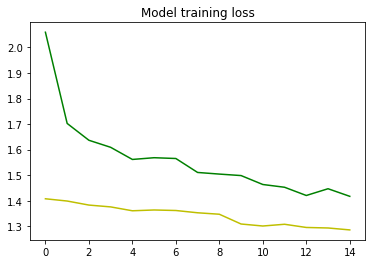

In [52]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylim([])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

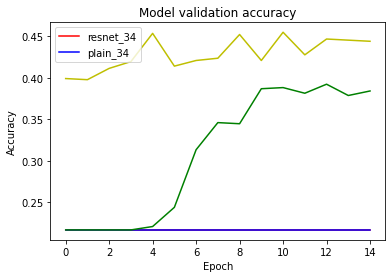

In [51]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

In [49]:
import pandas as pd

# 모델들의 history 객체 저장
histories = {
    "ResNet-34": history_resnet_34.history,
    "Plain-34": history_plain_34.history,
    "ResNet-50": history_resnet_50.history,
    "Plain-50": history_plain_50.history,
}

# 마지막 에포크의 val_ 값만 저장
rows = []
for model_name, history_dict in histories.items():
    last_epoch_val_data = {metric: values[-1] for metric, values in history_dict.items() if metric.startswith('val_')}
    last_epoch_val_data['Model'] = model_name  # 모델 이름 추가
    rows.append(last_epoch_val_data)

# DataFrame으로 변환
final_val_df = pd.DataFrame(rows)

# 컬럼 순서 정리
final_val_df = final_val_df[['Model'] + [col for col in final_val_df.columns if col != 'Model']]

# 출력
print(final_val_df)

       Model  val_loss  val_accuracy
0  ResNet-34       NaN      0.216621
1   Plain-34       NaN      0.216621
2  ResNet-50  1.519227      0.384196
3   Plain-50  1.436124      0.444142


### 2차 회고  

모델을 구성하고 학습시키는 것까지 완료했지만 loss부분의 오류 때문에 아직 더 학습이 필요하다.
50층 모델을 확인했을 때에도 잔차연결층이 없는 모델의 성능이 더 좋은 결과가 나왔다.
이번엔 새로 모델을 구성한 뒤 에폭 수를 늘려서 다시 실험해봐야겠다